<a href="https://colab.research.google.com/github/Bogula/TestNews/blob/master/Copy_of_%22Automatic_document_classification%22_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem-solving with ML: automatic document classification

This notebook covers the material discussed in the ["Problem-solving with ML: automatic document classification"](https://cloud.google.com/blog/big-data/2018/01/problem-solving-with-ml-automatic-document-classification) blog post.

If you are not familiar with Python and Colab, or similar notebooks (Jupyter, Google DataLab), check [this brief pre-work notebook](https://colab.research.google.com/notebook#fileId=1hja-JpW5ZgMRU3B5X1oX1BVACTHvVbh9) showing how these tools can be used for data analysis.

## 1. Data input and pre-processing

We are loading this dataset locally, as a CSV file, and adding a column encoding the category as an integer (categorical variables are often better represented by integers than strings).
The dataset can also be downloaded from [its original source](http://mlg.ucd.ie/datasets/bbc.html).

In [0]:
import pandas as pd

In [0]:
#from google.colab import files
#uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [0]:
url = 'https://github.com/suraj-deshmukh/BBC-Dataset-News-Classification/blob/master/dataset/dataset.csv?raw=true'
df = pd.read_csv(url, encoding='ISO-8859-1')

In [0]:

#!pip StringIO 
#from io import StringIO
#df = pd.read_csv(uploaded['dataset.csv'])
df.head()
df['category_id'] = df['type'].factorize()[0]

In [0]:
category_id_df = df[['type', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'type']].values)

## 2. Data exploration

Before diving head-first into training machine learning models, we should become familiar with the structure and characteristics of our dataset: these properties might inform our problem-solving approach.

A first step would be to look at some random examples, and the number of examples in each class:

In [10]:
df.sample(5, random_state=0)

,news,type,category_id
384,Jobs go at Oracle after takeover\n \n Oracle h...,business,0
1983,Virgin Radio offers 3G broadcast\n \n UK broad...,tech,4
985,Kennedy looks to election gains\n \n They may ...,politics,2
1386,Pountney handed ban and fine\n \n Northampton ...,sport,3
1294,UK set to cut back on embassies\n \n Nine over...,politics,2


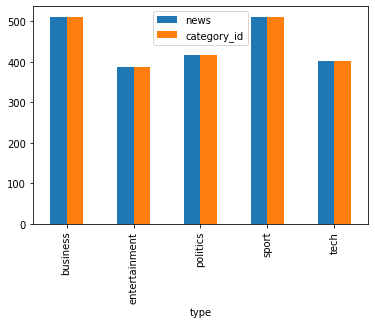

In [13]:
df.groupby('type').count().plot.bar(ylim=0)

Here, we see that the number of articles per class is roughly balanced, which is helpful! If our dataset were imbalanced, we would need to carefully configure our model or artificially balance the dataset, for example by [undersampling or oversampling](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis) each class.

To further analyze our dataset, we need to transform each article's text to a feature vector, a list of numerical values representing some of the text’s characteristics. This is because most ML models cannot process raw text, instead only dealing with numerical values.

One common approach for extracting features from text is to use the bag of words model: a model where for each document, an article in our case, the presence (and often the frequency) of words is taken into consideration, but the order in which they occur is ignored.

Specifically, for each term in our dataset, we will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf. This statistic represents words’ importance in each document. We use a word's frequency as a proxy for its importance: if "football" is mentioned 25 times in a document, it might be more important than if it was only mentioned once. We also use the document frequency (the number of documents containing a given word) as a measure of how common the word is. This minimizes the effect of stop-words such as pronouns, or domain-specific language that does not add much information (for example, a word such as "news" that might be present in most documents).
We will use sklearn (also known as scikit-learn), a machine learning library that is particularly accessible to beginners.
We use the `TfidfVectorizer` class to calculate a `tf-idf` vector for each of our documents:

`sklearn.feature_extraction.text.TfidfVectorizer` will be used to calculate a `tf-idf` vector for each of our documents. Note that we are passing a number of parameters to this class:

- `sublinear_df` is set to `True` to use a logarithmic form for frequency, to give diminishing returns as the frequency of a word increases. This is usually preferable for a number of reasons, one of which being [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law).
- `min_df` is the minimum numbers of documents a word must be present in to be kept, and we are setting it to `5`. This is to avoid rare words, which drastically increase the size of our features and might cause [overfitting](https://en.wikipedia.org/wiki/Overfitting).
- `norm` is set to `l2`, to ensure all our feature vectors have a euclidian norm of 1. This is helpful for visualizing these vectors, and can also improve (or deteriorate) the performance of some models.
- `encoding` is set to `latin-1` which is used by our input text.
- `ngram_range` is set to `(1, 2)` to indicate that we want to consider both unigrams and bigrams, or in other terms: we want to consider single words ("prices", "player") and pairs of words ("stock prices", "football player").
- Finally, `stop_words` is set to `"english"` to remove all common pronouns (`"a"`, `"the"`, ...) and further reduce the number of noisy features.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.news).toarray()
labels = df.category_id
features.shape

(2225, 14415)

Each of our 2225 documents is now represented by 14415 features, representing the tf-idf score for different unigrams and bigrams.

This representation is not only useful for solving our classification task, but also to familiarize ourselves with the dataset. For example, we can use the [chi-squared test](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test) to find the terms are the most correlated with each of the categories:

In [20]:
import numpy as np
from sklearn.feature_selection import chi2

N = 3
for type, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(type))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'business':
  . Most correlated unigrams:
       . oil
       . growth
       . shares
  . Most correlated bigrams:
       . analysts said
       . economic growth
       . stock market
# 'entertainment':
  . Most correlated unigrams:
       . singer
       . actor
       . film
  . Most correlated bigrams:
       . los angeles
       . film festival
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . prime minister
       . tony blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . coach
       . match
       . cup
  . Most correlated bigrams:
       . grand slam
       . australian open
       . champions league
# 'tech':
  . Most correlated unigrams:
       . technology
       . software
       . users
  . Most correlated bigrams:
       . anti virus
       . mobile phones
       . mobile phone


These result are consistent with what we would expect from a news outlet. We also notice that the addition of bigrams is welcome since it catches pairs of words that only make sense when put together (grand slam, box office, ...). Simply using this correlation factor to predict which class is the most likely might already get us quite far, but we will see that there are simpler and more efficient ways to do this.

Although this first test proves the presence of terms specific to each category, there might still be too much noise in the data, making it impossible to clearly separate each category. One way to confirm that the feature space we are using is representative enough for our task (classifying articles into separate labels) to be solvable is to use dimensionality-reduction techniques: These methods project a high-dimensional vector into a lower number of dimensions, with different guarantees on this projection according to the method used:

- Principal Component Analysis (PCA) and Truncated Singular Value Decomposition (Truncated SVD) are two popular method given their scalability to a large number of dimensions, but they perform poorly on some classes of problems (when the correlations between the data are non-linear).
- Kernel PCA, self-organizing maps and auto-encoders are often used when the correlations between the features' dimensions are non-linear.

Given our dataset contains natural language, we are most likely in the second case and will use [**t-SNE**](https://lvdmaaten.github.io/tsne/), a popular dimensionality reduction technique used in many fields, including NLP.

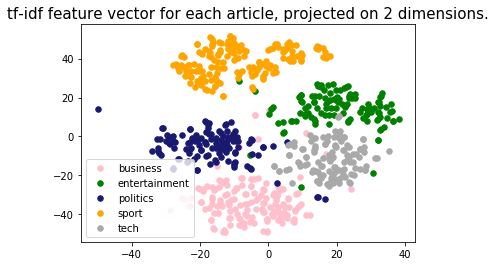

In [23]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
for type, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=type)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

More good news! We can clearly see that different article categories fall in different areas, which means that we should expect this problem to be easily solvable, achieving good performance.

One thing to note however is the presence of some *outliers*: points from a category falling in the middle of a different category. One of these outliers is a business article about the football club Arsenal, falling in the middle of a sport cluster:

In [25]:
df[df.news.str.contains('Arsenal')]

,news,type,category_id
331,Arsenal 'may seek full share listing'\n \n Ars...,business,0
1317,Bees handed potential Man Utd tie\n \n Brentfo...,sport,3
1329,Wenger steps up row\n \n Arsene Wenger has ste...,sport,3
1332,Highbury tunnel players in clear\n \n The Foot...,sport,3
1347,Klinsmann issues Lehmann warning\n \n Germany ...,sport,3
1353,Beckham relief as Real go through\n \n David B...,sport,3
1354,Poll explains free-kick decision\n \n Referee ...,sport,3
1358,Reyes tricked into Real admission\n \n Jose An...,sport,3
1360,Adriano's Chelsea link rejected\n \n Adriano's...,sport,3
1365,Spain coach faces racism inquiry\n \n Spain's ...,sport,3


These outliers are expected, and there's often little we can do as trying to correctly label **all** points in our dataset will only lead to **overfitting**: building an overly complex model that does not generalize well to unseen datapoints. 

## 3. Model training and evaluation

With this initial data exploration achieved, we are now more familiar with the way data is represented, and relatively confident that Machine Learning is a good fit to solve our classification problem. We are now ready to experiment with different machine learning models, evaluate their accuracy and find the source of any potential issues.

### Metrics

First, it is vital to choose which metric to optimize. Accuracy (the % of correct classifications) is the most commonly used metric, but it is not always the right choice: if we are trying to detect fraudulent users on a website, which might constitute only 0.01% of the total number of users, a model that would classify **all** users as being non-fraudulent would have 99.99% accuracy! Because of this, we must carefully choose the right metric based on the task we are trying to solve.
Here, we are dealing with a multi-class classification task (trying to assign one label to each document, out of a number of labels). Given the relative balance of our dataset, accuracy does seem like a good metric to optimize for. If one of the labels was more important than the others, we would then weight it higher, or focus on its own results. For imbalanced datasets such as the one described above, it is common to look at the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), and optimize the Area Under the Curve (ROC AUC).

### Choice of model, and *no free lunch*

`sklearn` provides implementations for a large number of machine learning models, spanning over different families:

- Linear models: Linear Regression, Logistic Regression, ...
- Ensemble models: Random Forest, Gradient Boosting Trees, Adaboost, ...
- Bayesian models: (Multinomial/Gaussian/...) Naive Bayes, Gaussian Processes, ...
- Support Vector Machines, k-Nearest Neighbors, and various other models.


`sklearn` however does not implement deep learning models (implemented in other libraries: `tensorflow`, `theano`, `pytorch`, ...) or more specialized models such as Bayesian graphical models, or sequenced-based models (Markov Chain, Hidden Markov Model, ...).

Ultimately, there is *no silver bullet*. This is a core principle of machine learning, illustrated by the *no free lunch* theorem: "any two optimization algorithms are equivalent when their performance is averaged across all possible problems", or in more practical terms: no model is universally superior to all other models, and the performance of a model greatly depends on the distribution of the data trained on and evaluated against.

Hence, we will benchmark the following three models:

- Logistic Regression: A linear classifier, mostly similar to traditional linear regression, but fitting the output of the logistic function.
- (Multinomial) Naive Bayes: A Bayesian model, assuming total independence between features. In our case, this means assuming that `P("football")` is unrelated to `P("stadium")`, which of course is a terrible assumption... and yet, this model still works surprisingly well with Bag of Words model, and were notably used for spam detection. 
- Random Forest: Random Forest (as the name might suggest) is the ensembling of a large number of decision trees, each trained on a random subset of the input features. They work well when complex feature-relations are involved, and are relatively robust to overfitting. 

We usually also perform a **hyperparameter search** for each model: tuning each of its "knobs" (number of trees for Random Forest, penalty for Logistic Regression) until we find the optimal ones. For simplicity, we skip this step below and directly provide reasonably good parameters for each model.

### Model evaluation
One common mistake when evaluating a model is to train and test it on the same dataset: this is problematic because you this will not evaluate how well the model works in realistic conditions, on unseen data, and models that overfit to the data will seem to perform better. 

It is common practice to split the data in three parts:
1. A training set that the model will be trained on.
1. A validation set used for finding the optimal parameters (as discussed previously).
1. A test set to evaluate the model’s performance.

Since we are not performing a hyperparameter search, we will only use a train/test split.

To evaluate each model, we will use the K-fold cross-validation technique: iteratively training the model on different subsets of the data, and testing against the held-out data. scikit-learn provides a utility function, `cross_val_score`, that allows us to run this operation in a single line of code!

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score
import seaborn as sns

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

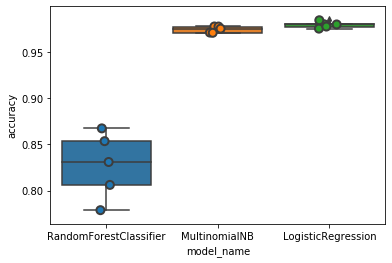

In [29]:

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

In [30]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.979323
MultinomialNB             0.974387
RandomForestClassifier    0.827485
Name: accuracy, dtype: float64

The results for the `RandomForest` model show a large variance, the sign of a model that is overfitting to its training data. Running cross-validation is vital, because results from a single train/test split might be misleading.
We also notice that both `MultinomialNB` (Naive Bayes) and `LogisticRegression` perform extremely well, with `LogisticRegression` having a slight advantage with a median accuracy of around 97%!
With such results, we could just pack our things and consider the task complete, but it’s good to apply a healthy dose of skepticism especially when results are this good.

### 4. Model interpretation

It is insufficient to have a model that performs well according to a given metric: we must also have a model that we can understand and whose results we can explain.

We will start by training our model on part of the dataset, and then analyze the main sources of misclassification on the test set. One way to eliminate sources of error is to look at the confusion matrix, a matrix used to show the discrepancies between predicted and actual labels.

In [31]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state=0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Text(0.5, 15.0, 'Predicted')

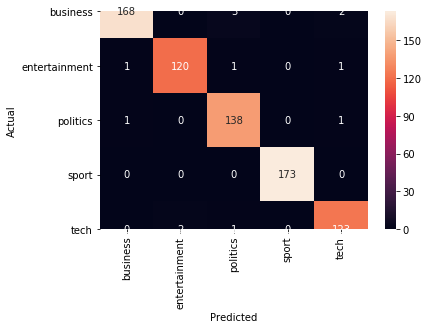

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.type.values, yticklabels=category_id_df.type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Given the extremely high accuracy of our model, the vast majority of the predictions end up on the diagonal (predicted label = actual label), where we want them to be! However, there are a number of misclassifications, and it might be interesting to see what those are caused by:

In [35]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 2:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['news']])
      print('')

'tech' predicted as 'entertainment' : 2 examples.


,news
2061,BBC leads interactive Bafta wins\n \n The BBC ...
2129,Half-Life 2 sweeps Bafta awards\n \n PC first ...



'business' predicted as 'politics' : 3 examples.


,news
459,Golden rule 'intact' says ex-aide\n \n Chancel...
478,Call to overhaul UK state pension\n \n The UK ...
393,Saudi ministry to employ women\n \n Women will...



'business' predicted as 'tech' : 2 examples.


,news
48,Call centre users 'lose patience'\n \n Custome...
262,Brussels raps mobile call charges\n \n The Eur...


As can be seen above, the misclassified articles are articles that touch on different subjects (for example, articles involving both politics and business) and might hence even be missclassified by humans. This sort of errors will always happen, and it is unrealistic to aim for a model that achieves 100% accuracy.

We can also look deeper inside the model and how it works, by finding which terms contribute the most to a document being classified in each of the categories:

In [36]:
model.fit(features, labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
from sklearn.feature_selection import chi2

N = 5
for type, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(type))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'business':
  . Top unigrams:
       . company
       . shares
       . bank
       . market
       . firm
  . Top bigrams:
       . chief executive
       . stock market
       . analysts said
       . economic growth
       . oil prices
# 'entertainment':
  . Top unigrams:
       . film
       . music
       . singer
       . tv
       . star
  . Top bigrams:
       . box office
       . los angeles
       . new york
       . film festival
       . big brother
# 'politics':
  . Top unigrams:
       . labour
       . party
       . mr
       . government
       . election
  . Top bigrams:
       . mr blair
       . tony blair
       . prime minister
       . general election
       . mr brown
# 'sport':
  . Top unigrams:
       . match
       . cup
       . club
       . win
       . game
  . Top bigrams:
       . year old
       . australian open
       . champions league
       . world number
       . bbc sport
# 'tech':
  . Top unigrams:
       . computer
       . users
       . 

This seems consistent with the terms we would expect, with the exception of the "tech" category, where the bigrams **`"bbc news"`** and **`"news website"`** are some of the most predictive. We also see that the **`"sport"`** category includes **`"bbc sport"`** as one of the most predictive bigrams.

This is confirmed by looking at the frequency of each category for articles containing **`"news website"`**:

In [42]:
df[df.news.str.lower().str.contains('news website')].type.value_counts()

tech             69
politics          8
entertainment     7
business          1
Name: type, dtype: int64

What is most likely happening is that the editorial style of the **"tech"** section is different, and often includes ther terms **`"bbc news"`**  and **`"news website"`**, in the same way the sports section includes **`"bbc sport"`**.

This is called a [**data leakage**](https://www.kaggle.com/wiki/Leakage), which is when information about the label we want to predict is accidentally added to the training set. In this specific case, our model still works equally good when excluding the leaky terms, but it's always good to be skeptical when a model performs unexpectedly well, hence the need for interpretable model instead of black-boxes that might work very well on the test set, but fail on real data.

For the record, we can also confirm that the model works well on data unrelated to the BBC, as can be seen in the examples below:

In [43]:
texts = ["Hooli stock price soared after a dip in PiedPiper revenue growth.",
         "Captain Tsubasa scores a magnificent goal for the Japanese team.",
         "Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions.",
         "Beyoncé releases a new album, tops the charts in all of south-east Asia!",
         "You won't guess what the latest trend in data analysis is!"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"Hooli stock price soared after a dip in PiedPiper revenue growth."
  - Predicted as: 'business'

"Captain Tsubasa scores a magnificent goal for the Japanese team."
  - Predicted as: 'sport'

"Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions."
  - Predicted as: 'politics'

"Beyoncé releases a new album, tops the charts in all of south-east Asia!"
  - Predicted as: 'entertainment'

"You won't guess what the latest trend in data analysis is!"
  - Predicted as: 'tech'

